# [DEMO] Part 3: Automated Model Search

## Overview
This notebook covers **Phase 3: Automated Model Search** of the LEGO modeling workflow. Building on the features and driver pool selection from Parts 1 & 2, we will:

1. **Define Search Constraints**: Specify the driver pool, forced-in variables, and limits (max variables, lags)
2. **Execute Automated Search**: Run exhaustive model combination testing with built-in validation
3. **Analyze Results**: Review candidate models that pass statistical tests, and diagnose failures

**Reference**: See section 1.2 (Phase 3) of The LEGO Playbook.

**What happens under the hood**: The search algorithm iterates through variable combinations, fits OLS models, and applies basic tests (stationarity, multicollinearity via VIF, p-value significance). Only models passing these tests are saved; others are discarded.

By the end, we'll have a curated set of **Candidate Models (CMs)** saved to disk, ready for evaluation in Part 4.

## Step 1: Load Packages and Prepared Data

**What we're doing**: Reload the LEGO framework and the DataManager/Segment from Part 1.

**Key concept**: All downstream steps (search, evaluation, export) depend on the unified data and segment configuration established in Part 1.

In [5]:
import pandas as pd
import Technic as tc
from Technic import TSFM, DumVar

In [6]:
from DEMO_1_Setup import *

## Step 2: Automated Model Search Configuration & Execution

**What we're doing**: Define constraints for the search and trigger automated model testing.

**Key parameters**:
- **forced_in**: Variables that must appear in every model (e.g., seasonal dummies)
- **desired_pool**: Universe of variables to test in combinations
- **max_var_num**: Maximum number of variables allowed per model
- **max_lag**: Maximum lag depth to test for variables

**Output**: Models are saved to disk under `Segment/<segment_id>/cms/`. Only passing models are retained; others are logged for debugging.

In [ ]:
# ============================================================================
# Define Candidate Variables & Search Constraints
# ============================================================================

# Variables that must appear in every model (e.g., seasonal indicators)
# DumVar('M', categories=[...]) forces monthly seasonal dummies for specified months
forced_in = [DumVar('M', categories=[2,3,4,5,10,11,12])]  # Exclude Jan, Jun, Jul, Aug, Sep, Dec

# Variables to consider in combinations (refined from EDA)
# Based on Part 2 correlation analysis, select variables with:
# - Clear economic logic
# - Reasonable correlation with target
# - Non-redundant (avoid highly collinear pairs)
desired_pool = [
    'USCORPAA10Y', 'USCORPBBB10Y',  # Corporate rates (credit conditions)
    'USHHPDI',                       # Household disposable income
    
    # Mortgage & key rates (financing channel)
    'USMORT30Y', 'USMORT15Y',       # Mortgage rates (housing cost)
    'USPRIME', 'USFF',              # Policy rates
    'USGOV10Y', 'USGOV2Y',          # Treasury yields
    
    # Optional: yield curve / term premia (uncomment to expand search)
    # 'USYC10_2', 'USYC10_6M', 
    # 'USREAL_TERM_PREM_PROXY', 'USMORT30_T10_SPRD',
]

print(f"Desired driver pool: {len(desired_pool)} variables")
print(f"Forced variables: Monthly seasonal dummies")
print(f"Search constraints: max_var_num=5, max_lag=3")
print("-" * 70)

# ============================================================================
# Execute Automated Search
# ============================================================================
# The search_cms() method will:
# 1. Iterate through all combinations of forced_in + subsets of desired_pool
# 2. For each combination, test lags from 0 to max_lag
# 3. Fit OLS model and run basic tests (VIF, stationarity, significance)
# 4. Save passing models to disk, discard failures
#
# This is computationally intensive (~minutes to hours depending on pool size),
# but only runs once; models are cached for later use.

seg.search_cms(
    forced_in=forced_in,
    desired_pool=desired_pool,
    max_var_num=5,        # Max variables per model (excluding forced_in)
    max_lag=3,            # Test lags 0, 1, 2, 3 for each variable
)

In [8]:
forced_in = [DumVar('M', categories=[2,3,4,5,10,11,12]),]
desired_pool = [
    'USCORPAA10Y', 'USCORPBBB10Y', 'USHHPDI', 
    # Mortgage & key rates (financing channel)
    'USMORT30Y', 'USMORT15Y', 'USPRIME', 'USFF', 'USGOV10Y', 'USGOV2Y',

    # # Yield curve / term premia
    # 'USYC10_2', 'USYC10_6M', 'USREAL_TERM_PREM_PROXY', 'USMORT30_T10_SPRD',

]

def test_update_func(mdl):
    update_map = {
        'In-Sample R-sq': {'filter_mode': 'strict',
                           'thresholds': {'strict': 0.7, 'moderate': 0.5}},
    }
    return update_map

seg.search_cms(
    forced_in=forced_in,
    desired_pool=desired_pool,
    max_var_num=5,
    max_lag=3,
)

=== ModelSearch Configuration ===
Target          : home_price_GR1
Model class     : OLS
Desired pool    : ['USCORPAA10Y', 'USCORPBBB10Y', 'USHHPDI', 'USMORT30Y', 'USMORT15Y', 'USPRIME', 'USFF', 'USGOV10Y', 'USGOV2Y']
Forced in       : [DumVar:M:2'3'4'5'10'11'12]
Sample          : in
Max var num     : 5
Max lag         : 3
Periods         : [1, 3, 6, 12]
Category limit  : 1
Regime limit    : None
Exp sign map    : None
Top N           : 10
Rank weights    : (1, 1, 1)
Model test update func: None
Pretest update func   : None
Outlier idx     : None


--- Target Pre-Test Result ---
Target Stationarity Test Result:
      Statistic   P-value Sample Filter Sample  Passed
Test                                                  
ADF   -2.187225  0.210915     In            In   False
PP    -3.330820  0.013556     In            In    True
ADF   -2.345871  0.157600   Full            In   False
PP    -3.562540  0.006519   Full            In    True

Target filter passed: True

⚠️Please review the ag

--- Feature Pre-Test Exclusions ---
Feature Stationarity (47): TSFM:USCORPAA10Y_LV, TSFM:USCORPAA10Y_LV_L1, TSFM:USCORPAA10Y_LV_L2, TSFM:USCORPAA10Y_LV_L3, TSFM:USCORPAA10Y_MMDF12, TSFM:USCORPAA10Y_MMDF12_L1, TSFM:USCORPAA10Y_MMDF12_L2, TSFM:USCORPBBB10Y_LV, TSFM:USCORPBBB10Y_LV_L1, TSFM:USCORPBBB10Y_LV_L2, TSFM:USCORPBBB10Y_LV_L3, TSFM:USCORPBBB10Y_MMDF12_L1, TSFM:USFF_LV, TSFM:USFF_LV_L1, TSFM:USFF_LV_L2, TSFM:USFF_LV_L3, TSFM:USFF_MMDF12, TSFM:USFF_MMDF12_L1, TSFM:USFF_MMDF12_L2, TSFM:USFF_MMDF12_L3, TSFM:USFF_MMDF6, TSFM:USFF_MMDF6_L1, TSFM:USGOV10Y_LV, TSFM:USGOV10Y_LV_L1, TSFM:USGOV10Y_LV_L2, TSFM:USGOV10Y_LV_L3, TSFM:USGOV2Y_LV_L2, TSFM:USHHPDI_LV, TSFM:USHHPDI_LV_L1, TSFM:USHHPDI_LV_L2, TSFM:USHHPDI_LV_L3, TSFM:USMORT15Y_LV, TSFM:USMORT15Y_LV_L1, TSFM:USMORT15Y_LV_L2, TSFM:USMORT15Y_LV_L3, TSFM:USMORT15Y_MMDF12, TSFM:USMORT15Y_MMDF12_L1, TSFM:USMORT15Y_MMDF12_L2, TSFM:USMORT15Y_MMDF12_L3, TSFM:USMORT30Y_LV, TSFM:USMORT30Y_LV_L1, TSFM:USMORT30Y_LV_L2, TSFM:USMORT30Y_LV_L3, TSFM:

KeyboardInterrupt: 

In [ ]:
# ============================================================================
# Step 3: Analyze Search Results & Diagnose Failures
# ============================================================================

# Review which models passed tests and which failed (and why)
# This is critical for debugging and improving the driver pool / constraints
print("\n" + "="*70)
print("SEARCH RESULTS ANALYSIS")
print("="*70)
seg.searcher.analyze_failures()


=== Failed Spec Combinations Analysis ===
Total failed spec combos: 401

1) Failure counts by test:
               Test Name  Failure Count
Coefficient Significance            401


2) Top 5 most frequent failed tests and their common spec elements:

  Test: Coefficient Significance
    Number of combos that failed this test: 401
    Top 3 spec elements contributing to this failure:
      • DumVar:M  (appeared in 401 combos)
      • TSFM:USHHPDI_MMDF_L1  (appeared in 29 combos)
      • TSFM:USHHPDI_MMDF_L2  (appeared in 29 combos)



=== Candidate Models to Report ===
- cm1: OLS-HAC(4):home_price_GR1~C+M:2+M:3+M:4+M:5+M:6+M:7+M:8+M:9+M:10+M:11+M:12+USCORPBBB10Y_MMDF12+USHHPDI_MMDF
- cm2: OLS-HAC(4):home_price_GR1~C+M:2+M:3+M:4+M:5+M:6+M:7+M:8+M:9+M:10+M:11+M:12+USCORPBBB10Y_MMDF6_L1+USHHPDI_MMDF
- cm3: OLS-HAC(4):home_price_GR1~C+M:2+M:3+M:4+M:5+M:6+M:7+M:8+M:9+M:10+M:11+M:12+USCORPBBB10Y_MMDF12+USHHPDI_MMDF3
- cm4: OLS-HAC(4):home_price_GR1~C+M:2+M:3+M:4+M:5+M:6+M:7+M:8+M:9+M:10+M:11+M:12
- cm5: OLS-HAC(4):home_price_GR1~C+M:2+M:3+M:4+M:5+M:6+M:7+M:8+M:9+M:10+M:11+M:12+USCORPAA10Y_MMDF


=== In-Sample Performance ===
         R²  Adj R²    ME   MAE  RMSE
Model                                
cm1   0.415   0.377 0.019 0.005 0.007
cm2   0.409   0.370 0.019 0.005 0.007
cm3   0.417   0.379 0.018 0.005 0.007
cm4   0.361   0.326 0.019 0.005 0.007
cm5   0.375   0.337 0.020 0.005 0.007

=== Out-of-Sample Performance ===
Metric    ME   MAE  RMSE
Model                   
cm1    0.007 0.003 0.004
cm2    0.007 0.003 0.004
cm3

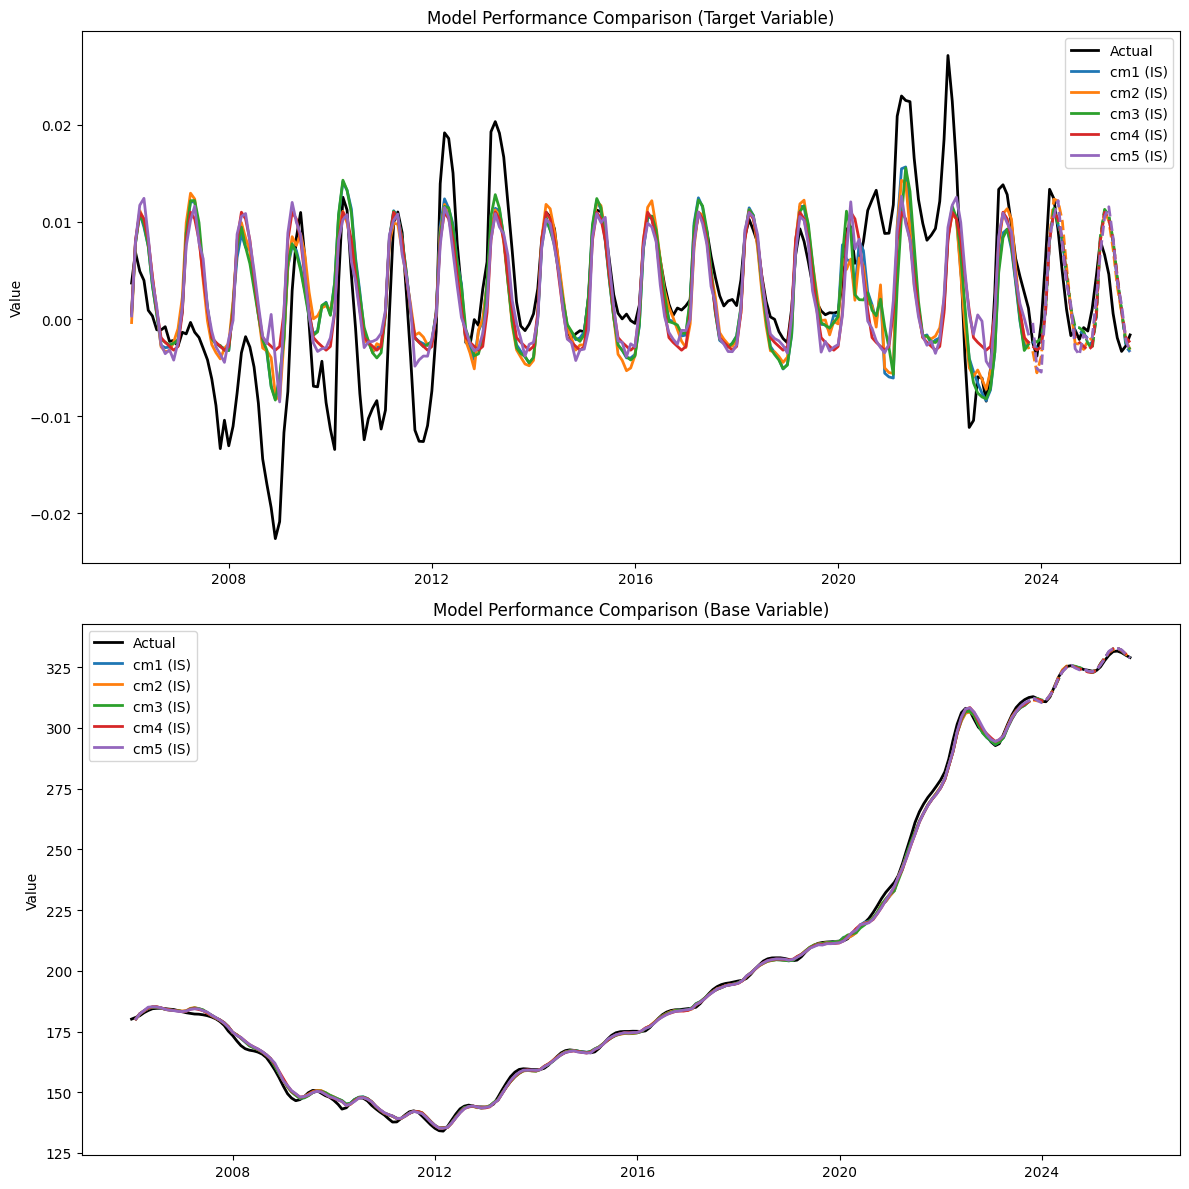

In [ ]:
# ============================================================================
# Step 4: Summary Report of Candidate Models
# ============================================================================

# Display a summary of all saved candidate models
# Shows R², AIC, BIC, and diagnostic metrics for each model
# This report will be used in Part 4 (Evaluation) to rank and select champions

print("\n" + "="*70)
print("SAVED CANDIDATE MODELS - SUMMARY REPORT")
print("="*70)
seg.show_report()